In [1]:
from src import *

import warnings
warnings.filterwarnings("ignore")

/Users/michaelc.c.h/opt/miniconda3/envs/brain2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Description

We visualize joints plots for 1st and 2nd eigenvectors of affinity matrices (i.e Gradients) and visualize their projection on cortical sufaces. 

GOAL: Joint plot 1st and 2nd connectivity gradients to visualize general topology and unimodal/transmodal distributions during rest and movie watching.

## Table of Contents
- [Single Video Processing](#single)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces
    - Per subject computing gradient (static gradient on 1 subject)


- [All Video Processing](#all)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces
    - Group level computing gradient (static gradient on all subjects (concatenated for now))
    - Loadings of affinity matrices

In [3]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [4]:
# We look at the same movie data but simply include subcortical in one of the sets
mri_path400 = "./data/fmri400_compiled/"
mri_path414 = "./data/fmri414_compiled/"

print(os.listdir(mri_path400))
print(os.listdir(mri_path414))

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']
['Rest_compiled414.csv', 'AfterTheRain_compiled414.csv']


<a class="anchor" id="single"></a>
### Single Video Processing

#### Functional Connectivity Matrix and Gradient computation

In [4]:
# Example of movies to load and compute
movie_name400   = 'AfterTheRain_compiled.csv'
mri_df400mov    = pd.read_csv(mri_path400 + movie_name400)
mri_df400rest   = pd.read_csv(mri_path400 + "Rest_compiled.csv")


movie_name414   = 'AfterTheRain_compiled414.csv'
mri_df414mov    = pd.read_csv(mri_path414 + movie_name414)
mri_df414rest   = pd.read_csv(mri_path414 + "Rest_compiled414.csv")

film_duration = FILM2DURATION[movie_name400.split('_')[0]] # in seconds
duration_film = int(film_duration/ TR) # in number of TRs
front_pad     = int(WASH + ONSET) + 1

In [5]:
filename_movie400 = mri_df400mov.filename.iloc[1000000]
filename_rest400  = mri_df400rest.filename.iloc[1000000]

filename_movie414 = mri_df414mov.filename.iloc[1000000]
filename_rest414  = mri_df414rest.filename.iloc[1000000]
print(filename_movie400)
print(filename_rest400)
print(filename_movie414)
print(filename_rest414)


movie_series400, _ = df_to_timeseries(mri_df400mov, filename_movie400)
movie_series400    = movie_series400[front_pad : front_pad + duration_film]
movie_series414, _ = df_to_timeseries(mri_df414mov, filename_movie414)
movie_series414    = movie_series414[front_pad : front_pad + duration_film]

rest_series400,  _ = df_to_timeseries(mri_df400rest, filename_rest400)
rest_series414,  _ = df_to_timeseries(mri_df414rest, filename_rest414)


fc_movie400 = FC(movie_series400)
fc_rest400  = FC(rest_series400)
fc_movie414 = FC(movie_series414)
fc_rest414  = FC(rest_series414)

TC_400_sub-S13_ses-1_AfterTheRain.csv
TC_400_sub-S04_ses-1_Rest.csv
TC_414_sub-S13_AfterTheRain.csv
TC_414_sub-S04_Rest.csv


In [6]:
g_rest400  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
g_rest400.fit(fc_rest400)

g_movie400 = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs, alignment=align_meth)
g_movie400.fit(fc_movie400, reference=g_rest400.gradients_)

# print("Alignement score movies on rests': {}".format(procrustes_score(g_rest400.gradients_, g_movie400.aligned_)))

g_rest414  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
g_rest414.fit(fc_rest414)

g_movie414 = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs, alignment=align_meth)
g_movie414.fit(fc_movie414, reference=g_rest414.gradients_)

# print("Alignement score movies on rests': {}".format(procrustes_score(g_rest414.gradients_, g_movie414.aligned_)))

GradientMaps(alignment='procrustes', kernel='pearson', n_components=3,
             random_state=99)

#### Joint Plot of 1st and 2nd Gradient (2d plot)
- G1 versus G2
- G1 versus G3 

1. G1 Versus G2

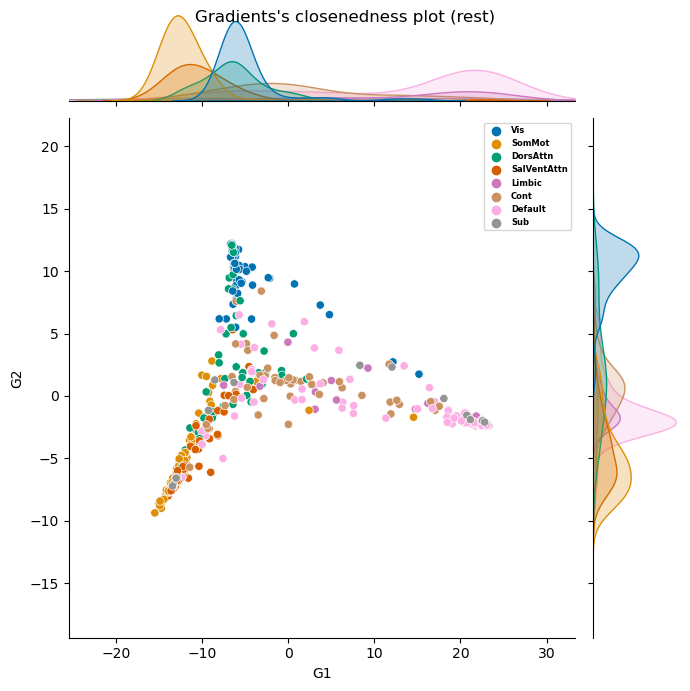

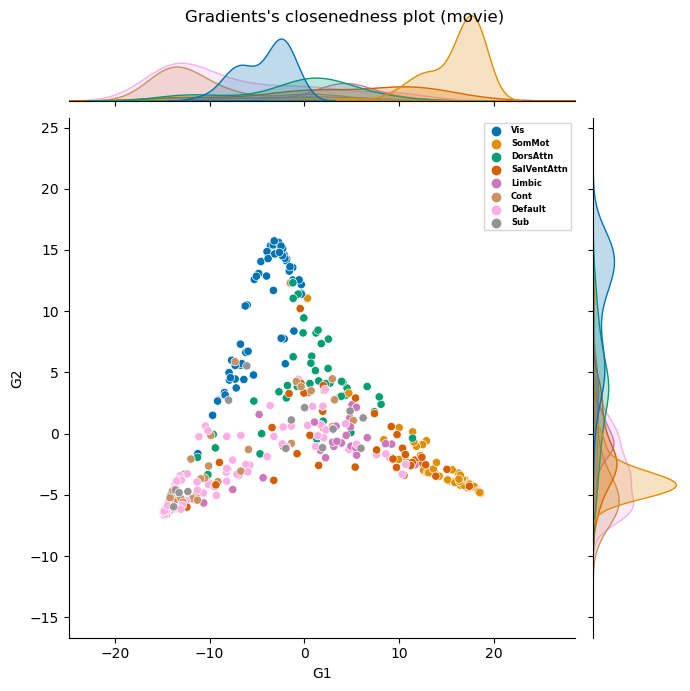

In [21]:
# 414 Parcellations
pal            = sns.color_palette('colorblind', 8)
partial_region = load('./resources/region414yeo7.pkl')
coloring       = [partial_region[i] for i in range(414)]

gs = [g_rest414, g_movie414]
ts = ['rest', 'movie']
for i in range(2):
    if i == 0:
        G = gs[i].gradients_
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    else:
        G = gs[i].gradients_
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", height=7, palette=pal, 
                    xlim=(G[:,0].min()-10,G[:,0].max()+10),
                    ylim=(G[:,1].min()-10,G[:,1].max()+10) )
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]), fontsize=12)
    legend_properties = {'weight':'bold','size':6}

    # ax.set_axis_labels('G1', 'G2', fontsize=10)

    ax.ax_joint.legend(prop=legend_properties,loc='upper right')
    ax.ax_joint.set_xlabel('G1',fontsize=10)
    ax.ax_joint.set_ylabel('G2',fontsize=10)

2. G1 Versus G3s

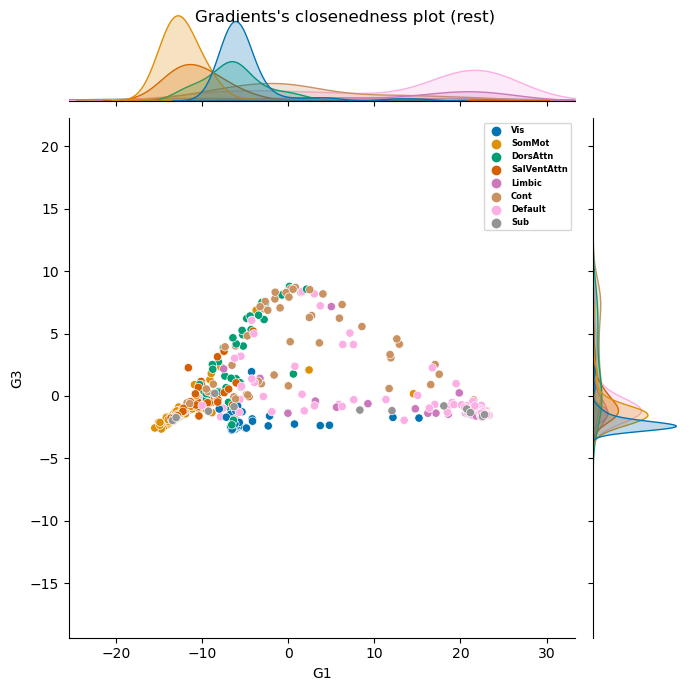

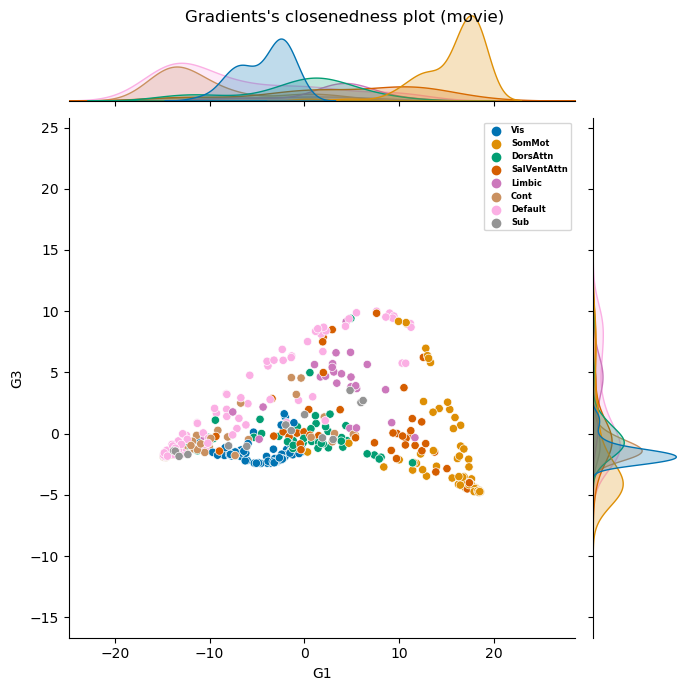

In [22]:
# 414 Parcellations
pal            = sns.color_palette('colorblind', 8)
partial_region = load('./resources/region414yeo7.pkl')
coloring       = [partial_region[i] for i in range(414)]

gs = [g_rest414, g_movie414]
ts = ['rest', 'movie']
for i in range(2):
    if i == 0:
        G = gs[i].gradients_
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G3": gs[i].gradients_[:,2], "region": coloring}
    else:
        G = gs[i].gradients_
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G3": gs[i].gradients_[:,2], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G3", hue="region", height=7, palette=pal, 
                    xlim=(G[:,0].min()-10,G[:,0].max()+10),
                    ylim=(G[:,1].min()-10,G[:,1].max()+10) )
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]), fontsize=12)
    legend_properties = {'weight':'bold','size':6}

    # ax.set_axis_labels('G1', 'G2', fontsize=10)

    ax.ax_joint.legend(prop=legend_properties,loc='upper right')
    ax.ax_joint.set_xlabel('G1',fontsize=10)
    ax.ax_joint.set_ylabel('G3',fontsize=10)

#### Joint Plot of First 3 Gradients (3d plot)
- Rest
- Movie 

In [13]:
from IPython.display import HTML
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(pal)

1. Rest Plot

In [27]:
from matplotlib import animation

partial_region = load('./resources/yeo7region414.pkl')


grad_rest  = gs[0].gradients_
grad_movie = gs[1].gradients_
grads = [grad_rest, grad_movie]
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
i   = 0 # 0 rest 1 movie
def init():
    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]

        marker = 'o' if net != 'Sub' else 'X'
        markersize = 20 if net != 'Sub' else 60
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx], marker=marker, s=markersize)
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc=5, prop={'size':5})
    ax.set_title("Gradients's closenedness plot ({})".format(ts[i]), size=15)

    ax.set_xlim(-15,20)
    ax.set_ylim(-15,15)
    ax.set_zlim(-5,10)

    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
frames=100, interval=100, blit=True) 

plt.close(fig)

HTML(ani.to_html5_video())

2. Movie Plot

In [28]:
from matplotlib import animation

partial_region = load('./resources/yeo7region414.pkl')


grad_rest  = gs[0].gradients_
grad_movie = gs[1].gradients_
grads = [grad_rest, grad_movie]
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
i   = 1 # 0 rest 1 movie
def init():
    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]

        marker = 'o' if net != 'Sub' else 'X'
        markersize = 20 if net != 'Sub' else 60
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx], marker=marker, s=markersize)
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc=5, prop={'size':5})
    ax.set_title("Gradients's closenedness plot ({})".format(ts[i]), size=15)

    ax.set_xlim(-15,20)
    ax.set_ylim(-15,15)
    ax.set_zlim(-5,10)

    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
frames=100, interval=100, blit=True) 

plt.close(fig)

HTML(ani.to_html5_video())

#### Visualization of Yeo-7 Parcellation on cortical/subcortical surface

Subcortical

In [19]:
with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

order = "left-accumbens, left-amygdala, left-caudate, left-hippocampus, left-pallidum, left-putamen, left-thalamus, right-accumbens, right-amygdala, right-caudate, right-hippocampus, right-pallidum, right-putamen, right-thalamus".split(',')
order = [' '.join(o.split('-')).strip() for o in order]
dataorder = [t.lower() for t in text]

orderidx = [order.index(o) for o in dataorder]

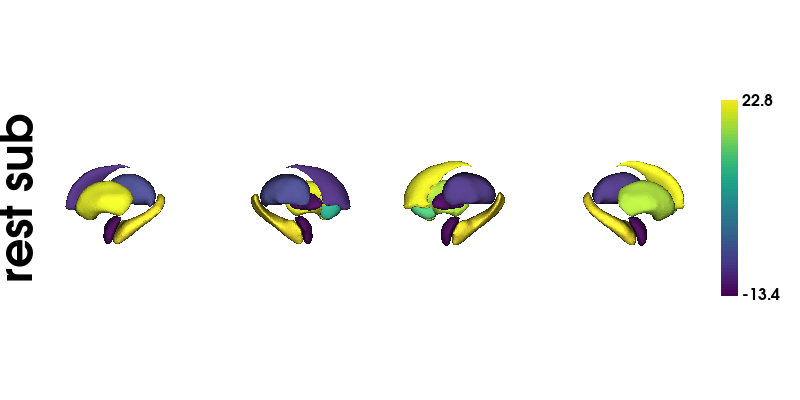

In [41]:
from enigmatoolbox.plotting import plot_subcortical


# "color-range" flag can be used if needed very useful instead of artificially
# Project the results on the surface brain
plot_subcortical(array_name=g_rest414.gradients_[400:,0][orderidx], ventricles=False, size=(800, 400),
                  cmap='viridis', color_bar=True,embed_nb=True, label_text=['rest sub'], interactive=False,transparent_bg=False)

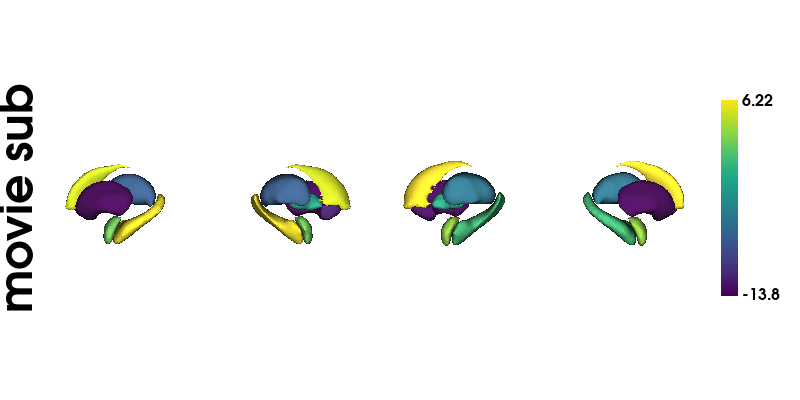

In [42]:
plot_subcortical(array_name=g_movie414.gradients_[400:,0][orderidx], ventricles=False, size=(800, 400),
                  cmap='viridis', color_bar=True,embed_nb=True, label_text=['movie sub'], interactive=False,transparent_bg=False)

Cortical

In [ ]:
# Parcellation 400
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0
gs   = [g_rest400, g_movie400]
grad = [None] * 4
for i in range(2):
    for k in range(2):
        # map the gradient to the parcels
        grad[i*2+k] = map_to_labels(gs[i].gradients_[:, k], labeling, mask=mask, fill=np.nan)
#         gs[i].gradients_[:, k]

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, color_range=[(-1,1),(-1,1),(-1,1),(-1,1)], label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad1-Movie', 'Grad2-Movie'], zoom=1.55, embed_nb=True, interactive=False,
                 transparent_bg=False)

#### Saving the Generated Gradients

##### Per subject computing gradient

In [5]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [15]:
# This Generates individual Gradients for 400 parcellations
# Note: Simply replace by 414 to save gradients with 414 regions (do remember to change the output filenames however) 
for i in tqdm(range(len(os.listdir(mri_path400)))):
    
    movie_name   = os.listdir(mri_path400)[i]
    mri_df       = pd.read_csv(mri_path400 + movie_name)
    if "Rest" in movie_name:
        front_pad = 0
        end       = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in second
        duration_film = int(film_duration/ TR) # in number of TRs
        front_pad     = int(WASH + ONSET) + 1
        end           = front_pad + duration_film

    subject_grad = {}
    acqui        = [k for k in mri_df.filename.unique() if '400' in k]
    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)

        movie_series    = movie_series[front_pad : end]

        fc = FC(movie_series)
        g  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        subject_grad[subject] = g.gradients_
    save('./resources/static_grad/individual_level/'+movie_name.split('_')[0]+'_grad400.pkl',subject_grad)

100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


##### Per Subject computing Movie Super Gradient

In [10]:
movies400 = [f for f in os.listdir('./resources/static_grad/individual_level/') if '400' in f and 'Rest' not in f]
movies414 = [f for f in os.listdir('./resources/static_grad/individual_level/') if '414' in f and 'Rest' not in f]

ind_grads  = [load('./resources/static_grad/individual_level/'+f) for f in movies414]
persubject = {k: [] for k in ind_grads[0].keys()}
for ind_grad in ind_grads:
    for k in ind_grad.keys():
        persubject[k].append(ind_grad[k])

for k in ind_grads[0].keys():
    # align first
    aligned, _ , _ = procrustes_align(persubject[k])
    persubject[k]  = np.asarray(aligned)
    persubject[k]  = persubject[k].mean(axis=0)

save('./resources/static_grad/individual_level/'+'SUPERMOVIE'+'_grad414.pkl',persubject)

<a class="anchor" id="all"></a>
### Multiple concatenated

#### Sanity Check 
Why do we plot 3 gradients for movies?/why would it be interesting in comparison to Rest which we usually use only 2 gradients.

In [5]:
# Rest Gradients Computation
rest_series  = []
mri_df400rest   = pd.read_csv(mri_path400 + "Rest_compiled.csv")
rests  = [m for m in mri_df400rest.filename.unique() if "400" in m]
for r in rests:
    tmp2, _ = df_to_timeseries(mri_df400rest, r)
    rest_series.append(tmp2)
rests_series  = np.concatenate(rest_series)

fc_rests  = FC(rests_series)

g_rests  = GradientMaps(n_components=10, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)



# Sintel movie Gradients Computation
front_pad = int(WASH + ONSET) + 1
film_duration = FILM2DURATION['Sintel'] # in seconds
duration_film = int(film_duration/ TR) # in number of TRs
end           = front_pad + duration_film

movie_series   = []
mri_df400movie = pd.read_csv(mri_path400 + "Sintel_compiled.csv")
movies  = [m for m in mri_df400movie.filename.unique() if "400" in m]
for r in movies:
    tmp2, _ = df_to_timeseries(mri_df400movie, r)
    movie_series.append(tmp2[front_pad:end])
movies_series  = np.concatenate(movie_series)

fc_movies  = FC(movies_series)

g_movies  = GradientMaps(n_components=10, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_movies.fit(fc_movies)

GradientMaps(kernel='pearson', random_state=99)

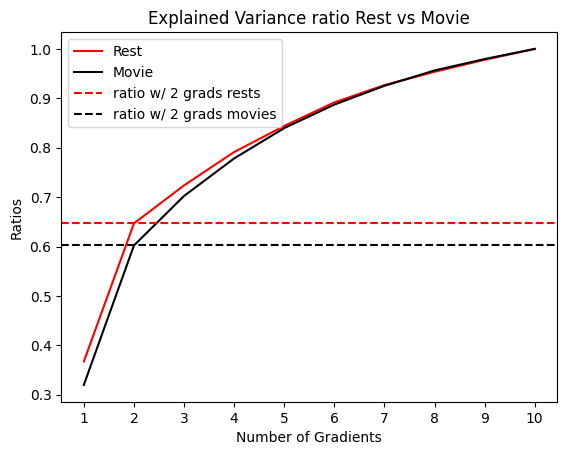

In [6]:
var_rests  = g_rests.lambdas_
var_movies = g_movies.lambdas_
var_rests /= var_rests.sum()
var_movies /= var_movies.sum()

plt.plot(np.arange(1,11),np.cumsum(var_rests), label='Rest', c='r')
plt.plot(np.arange(1,11),np.cumsum(var_movies), label='Movie', c='k')

plt.title('Explained Variance ratio Rest vs Movie')
plt.xlabel('Number of Gradients')
plt.ylabel('Ratios')

plt.axhline(y = np.cumsum(var_rests)[1], color = 'r', linestyle = '--', label='ratio w/ 2 grads rests')
plt.axhline(y = np.cumsum(var_movies)[1], color = 'k', linestyle = '--', label='ratio w/ 2 grads movies')

plt.xticks(np.arange(1,11))
plt.legend()
plt.show()

#### Functional Connectivity Matrix and Gradient loading

In [5]:
# load already computed static grad
static_path = './resources/static_grad/group_level/'
g_rests     = load(static_path + '/Rest_grad414.pkl')

In [6]:
# Supermovie by averaging all gradients movies per position
g_movies = [load(static_path + f) for f in os.listdir('./resources/static_grad/group_level/') if 'Rest' not in f and '414' in f]
g_movies, ref, score =  procrustes_align(np.asarray(g_movies))
g_movies = np.asarray(g_movies).mean(axis=0)
g_movies,_,score = procrustes_align([g_movies], ref=g_rests)
g_movies = g_movies[0]

#### Joint Plot of 1st and 2nd Gradient + 1st and 3rd Gradient (2D)

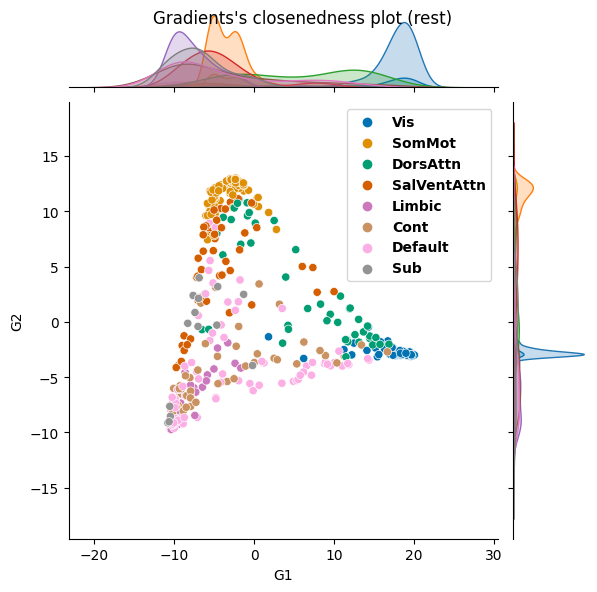

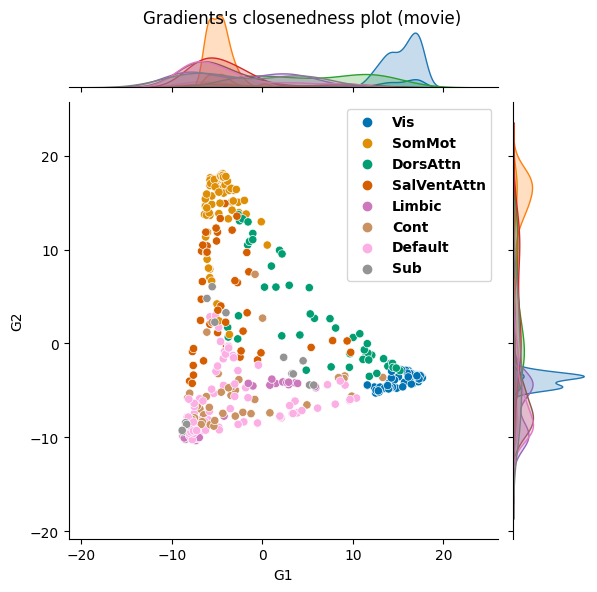

In [7]:
partial_region = load('./resources/region414yeo7.pkl')
coloring       = [partial_region[i] for i in range(414)]
pal            = sns.color_palette('colorblind', 8)

gs = [g_rests, g_movies]

ts = ['rest', 'movie']
for i in range(2):
    # we keep exact same coloring method: same encoding
    tmp_df = {"G1":gs[i][:,0] , "G2": gs[i][:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", palette=pal)
    df = pd.DataFrame.from_dict(tmp_df)

    for k in df.region.unique():
        data = df[df.region == k]

        sns.kdeplot(x=data.G1, fill=True, label=k, ax=ax.ax_marg_x)
        sns.kdeplot(y=data.G2, fill=True, label=k, ax=ax.ax_marg_y)

    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))

    legend_properties = {'weight':'bold','size':10}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


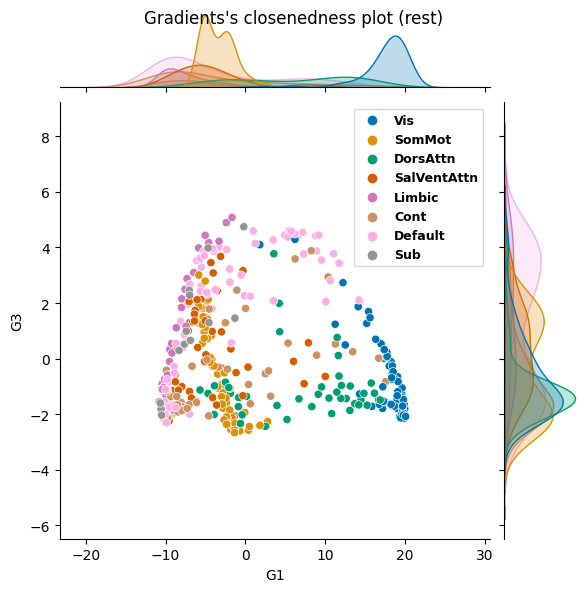

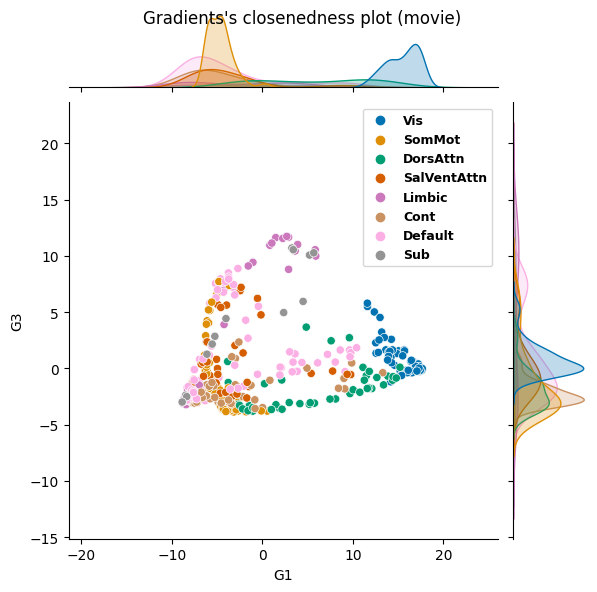

In [8]:
partial_region = load('./resources/region414yeo7.pkl')
coloring  = [partial_region[i] for i in range(414)]
pal       = sns.color_palette('colorblind', 8)

gs = [g_rests, g_movies]

ts = ['rest', 'movie']
for i in range(2):
    # we keep exact same coloring method: same encoding
    tmp_df = {"G1":gs[i][:,0] , "G3": gs[i][:,2], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G3", hue="region", palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':9}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


#### Joint Plot of First 3 gradients (3D)
- Rest (animation)
- Movie (animation)
- Rest (3d plot)
- Movie (3d plot)

1. Rest (animation)

In [10]:
from IPython.display import HTML
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(pal)
from matplotlib import animation

partial_region = load('./resources/yeo7region414.pkl')

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
i   = 0 # 0 rest 1 movie
grads = [g_rests, g_movies]

def init():
    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]

        marker = 'o' if net != 'Sub' else 'X'
        markersize = 20 if net != 'Sub' else 60
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx], marker=marker, s=markersize)
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc=5, prop={'size':5})
    ax.set_title("Gradients's Topology ({})".format(ts[i]), size=15)

    ax.set_xlim(-15,20)
    ax.set_ylim(-15,17)
    ax.set_zlim(-5,10)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)


    return fig,

def animate(i):
    ax.view_init(elev=20., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
frames=100, interval=100, blit=True) 

plt.close(fig)

HTML(ani.to_html5_video())

2. Movie (animation)

In [11]:
from matplotlib import animation

partial_region = load('./resources/yeo7region414.pkl')

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
i   = 1 # 0 rest 1 movie
grads = [g_rests, g_movies]

def init():
    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]

        marker = 'o' if net != 'Sub' else 'X'
        markersize = 20 if net != 'Sub' else 60
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx], marker=marker, s=markersize)
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc=5, prop={'size':5})
    ax.set_title("Gradients's Topology ({})".format(ts[i]), size=15)

    ax.set_xlim(-15,20)
    ax.set_ylim(-15,17)
    ax.set_zlim(-5,10)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)    

    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
frames=100, interval=100, blit=True) 

plt.close(fig)

HTML(ani.to_html5_video())

3. Rest (3D plot)

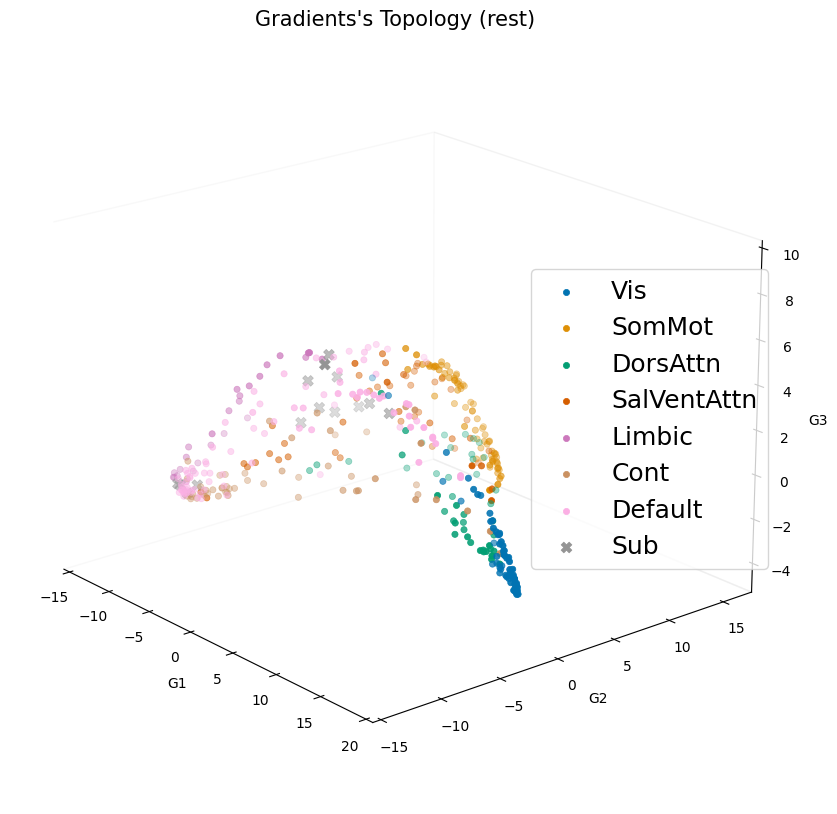

In [19]:
partial_region = load('./resources/yeo7region414.pkl')

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
i   = 0 # 0 rest 1 movie
grads = [g_rests, g_movies]

for idx,net in enumerate(partial_region.keys()):
    s = partial_region[net]

    marker = 'o' if net != 'Sub' else 'X'
    markersize = 20 if net != 'Sub' else 60
    ax.scatter(grads[i][s,0],
            grads[i][s,1],
            grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx], marker=marker, s=markersize)
ax.set_xlabel('G1', size=10)
ax.set_ylabel('G2', size=10)
ax.set_zlabel('G3', size=10)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc=5, prop={'size':18})
ax.set_title("Gradients's Topology ({})".format(ts[i]), size=15)

ax.set_xlim(-15,20)
ax.set_ylim(-15,17)
ax.set_zlim(-5,10)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.view_init(elev=20., azim=320)


4. Movie (3D plot)

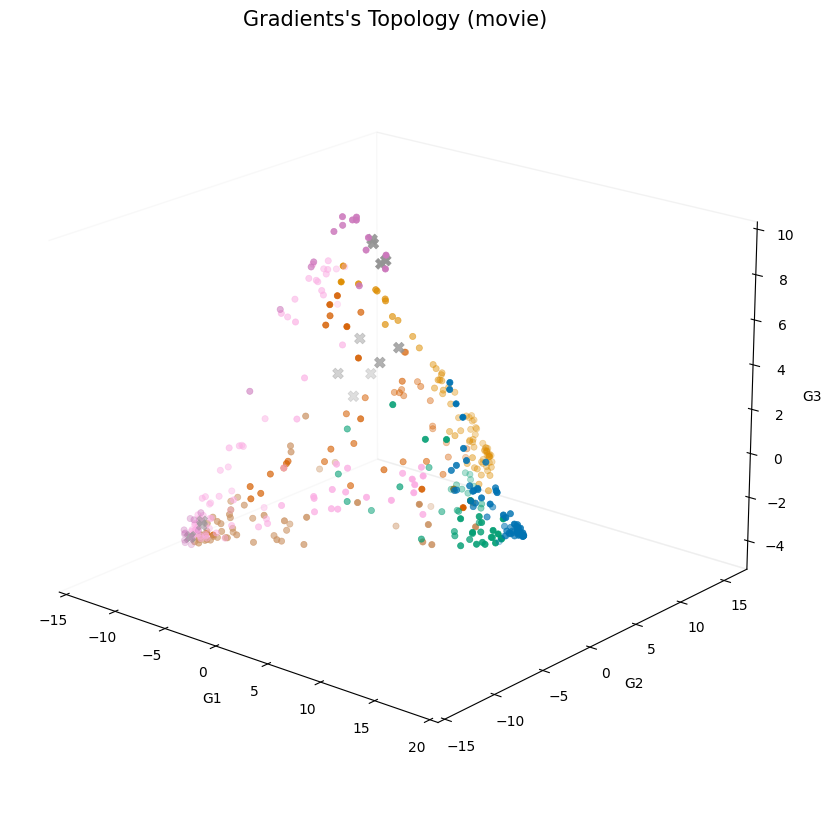

In [20]:
from matplotlib import animation

partial_region = load('./resources/yeo7region414.pkl')

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
i   = 1 # 0 rest 1 movie
grads = [g_rests, g_movies]

for idx,net in enumerate(partial_region.keys()):
    s = partial_region[net]

    marker = 'o' if net != 'Sub' else 'X'
    markersize = 20 if net != 'Sub' else 60
    ax.scatter(grads[i][s,0],
            grads[i][s,1],
            grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx], marker=marker, s=markersize)
ax.set_xlabel('G1', size=10)
ax.set_ylabel('G2', size=10)
ax.set_zlabel('G3', size=10)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), loc=5, prop={'size':10})
ax.set_title("Gradients's Topology ({})".format(ts[i]), size=15)

ax.set_xlim(-15,20)
ax.set_ylim(-15,17)
ax.set_zlim(-5,10)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.view_init(elev=20., azim=310)

#### Visualization of Yeo-7 Parcellation on cortical/subcortical surface

Cortical

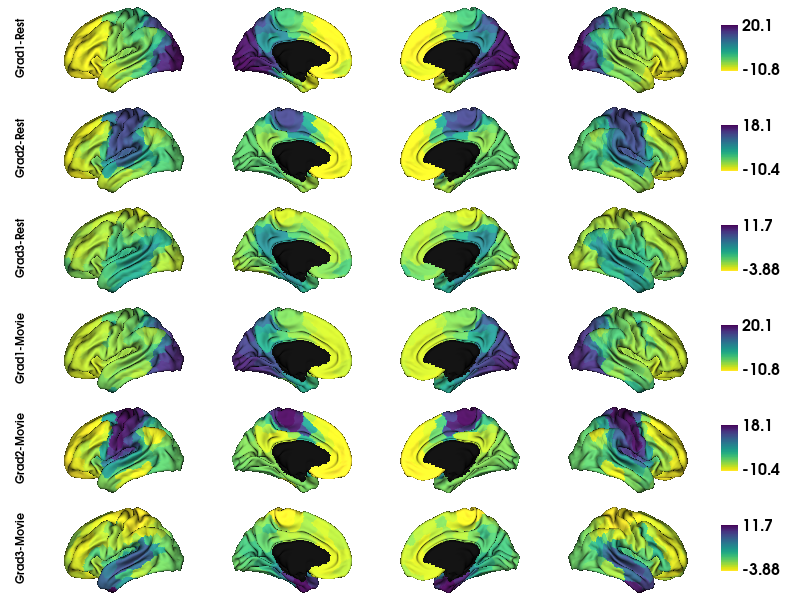

In [28]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

bounds = 2 * [(min(gs[0][:,i].min(), gs[1][:,i].min()), max(gs[0][:,i].max(), gs[1][:,i].max()))   for i in range(3)]
mask = labeling != 0
gs,_,_ = procrustes_align([g_rests, g_movies])
grad = [None] * 6
for i in range(2):
    for k in range(3):
        # map the gradient to the parcels
        grad[i*3+k] = map_to_labels(gs[i][:400, k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(800, 600), cmap='viridis_r',
                 color_bar=True, color_range=bounds, label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad3-Rest', 'Grad1-Movie', 'Grad2-Movie', 'Grad3-Movie'], zoom=1.55, embed_nb=True, interactive=False,
                 transparent_bg=False)


Subcortical

In [31]:
with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

order = "left-accumbens, left-amygdala, left-caudate, left-hippocampus, left-pallidum, left-putamen, left-thalamus, right-accumbens, right-amygdala, right-caudate, right-hippocampus, right-pallidum, right-putamen, right-thalamus".split(',')
order = [' '.join(o.split('-')).strip() for o in order]
dataorder = [t.lower() for t in text]

orderidx = [order.index(o) for o in dataorder]

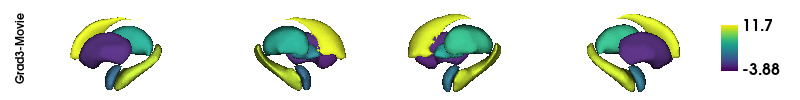

In [37]:
from enigmatoolbox.plotting import plot_subcortical


# "color-range" flag can be used if needed very useful instead of artificially
# Project the results on the surface brain

gidx = 2
movieflag = 1
if movieflag: 
    name = 'Movie'
else:
    name = 'Rest'
plot_subcortical(array_name=gs[movieflag][400:,gidx][orderidx], ventricles=False, size=(800, 100),
                cmap='viridis', color_bar=True,embed_nb=True, color_range=(min(gs[0][:,gidx].min(), gs[1][:,gidx].min()), 
                max(gs[0][:,gidx].max(), gs[1][:,gidx].max()))
                , label_text=['Grad{}-{}'.format(gidx+1, name)], interactive=False,transparent_bg=False, zoom=1.55)

#### Generating Group Level Static gradient (i.e 1 per movie)

In [65]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [67]:
# This Generates group Gradients for 400 parcellations
# Note: Simply replace by 414 to save gradients with 414 regions (do remember to change the output filenames however) 

for i in tqdm(range(len(os.listdir(mri_path414)))):
    movie_name   = os.listdir(mri_path414)[i]
    mri_df       = pd.read_csv(mri_path414 + movie_name)
    
    if "Rest" in movie_name:
        front_pad = 0
        end       = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        # trim the washimg time for movies before and after
        front_pad     = int(WASH + ONSET) + 1
        end           = front_pad + duration_film

    acqui = [k for k in mri_df.filename.unique() if '414' in k]
    tmp   = []
    for filename_movie in acqui:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : end]
        tmp.append(movie_series)
    movies_series = np.concatenate(tmp)

    fc = FC(movies_series)
    g  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    save('./resources/static_grad/group_level/'+movie_name.split('_')[0]+'_grad414.pkl',g.gradients_)

100%|██████████| 2/2 [00:42<00:00, 21.11s/it]
